# Pre-processing

In [ ]:
import glob
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/Dataset/Dataset.zip";

In [ ]:
training_fake_dir = glob.glob("/content/real_and_fake_face/training_fake/*")
training_real_dir = glob.glob("/content/real_and_fake_face/training_real/*")

In [ ]:
dataset = pd.DataFrame()
dataset['Image_ID'] = training_fake_dir
dataset['Label'] = "0"
dataset = dataset.append(pd.DataFrame({'Image_ID':training_real_dir, 'Label':"1"}), ignore_index=True)

In [ ]:
dataset = dataset.sample(frac=1)

In [ ]:
x_data = np.asarray([img_to_array(load_img(i, target_size=(60,60))) for i in dataset['Image_ID']])
y_data = np.asarray([int(i[0]) for i in dataset['Label']])
# y_data =dataset['Label'].to_numpy().astype('int')
y_data = y_data.astype(np.float32)

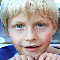

In [ ]:
Image.fromarray(x_data[0].astype(np.uint8))

Creating a .pickle file for data. Uncomment this code to create a pickle so that we don't have to keep processing the image.open multiple times.

The pickle has 2041*((600*600*3),1) shaped data of the image vector and the corresponding label.

First up I am trying to convert the images in the dataset to .pickle file which will store the dataset in the form of 3 channel 2D array for images and corresponding labels.

It will be easy to fetch and will save time in zipping converting img to array etc.

In [ ]:
data=[]
for i in range(0,len(x_data)):
  data.append([x_data[i],y_data[i]])

In [ ]:
% cd gdrive/MyDrive/Dataset/
pick_data = open('data.pickle','rb')
data = pickle.load(pick_data)
pick_data.close()
print(len(data))

/content/gdrive/MyDrive/Dataset
2041


In [ ]:
# Saving models with using pickle function:

def saveModel(model,modelName):
  model_pickle_name = modelName+"_pickle"
  model_pickle_name = open(modelName+".sav",'wb')
  pickle.dump(model,model_pickle_name)
  model_pickle_name.close()

In [ ]:
def retrieveModel(modelName):
  model = None
  model_pickle_name = modelName+"_pickle"
  model_pickle_name = open(modelName+".sav",'rb')
  model = pickle.load(model_pickle_name)
  model_pickle_name.close()
  return model

In [ ]:
def stratified_sampling(df, categories, n_samples, col):
  m = 30000000
  stratified_samples = []
  for i in categories:
    m=min(len(df.loc[df[col]==i]),m)
  print(m)
  for i in categories:
    stratified_samples.append(df.loc[df[col]==i].sample(m,replace=False))
    # stratified_samples.append(df.loc[df[col]==i].sample(n_samples,replace=True))
  
  _df = pd.concat(stratified_samples,axis=0)
  return _df

In [ ]:
#converting back to image from 2D array
def showImage(ingArr):
  img = Image.fromarray(ingArr)
  display(img)

In [ ]:
labels=[0.0,1.0]
_df = pd.DataFrame(data=data, columns=["Image","Label"])
# print(data.shape)
# _df = stratified_sampling(data,categories=labels,n_samples=1500,col="Label")
_df = _df.sample(frac=1)
data_train, data_test = train_test_split(_df, test_size=0.25, random_state=42)
_df.shape

(2041, 2)

Till the above cell the code is probably common for  all models.

# SVM

In [ ]:
x_train = []
y_train = data_train["Label"]
x_test = []
y_test =  data_test["Label"]
for i in range(0,len(data_train)):
  x_train.append(data_train["Image"].iloc[i].flatten())

for i in range(0,len(data_test)):
  x_test.append(data_test["Image"].iloc[i].flatten())

In [ ]:
x_train = np.array(x_train).astype('float32')
x_train = x_train/255.0
y_train = np.array(y_train).astype('int').reshape(len(y_train),)
x_test = np.array(x_test).astype('float32')
x_test = x_test/255.0
y_test = np.array(y_test).astype('int').reshape(len(y_test),)

In [ ]:
# x_train.shape
y_train

array([1, 0, 0, ..., 1, 1, 1])

SVM Classifier

Explore : Feature Engineering options like HOC,greyscale pixel value, mean pixel value, edge extraction etc. apart from using GridSearchCV

Using GridSearchCV to select the best hyperparameter values, C and gamma*

*when required. 

We need to convert the 2D image to 1D array and use that array for classification. resize and flatten is generally the approch for this. We can probably write better ways to resize by using maxpool or something like that.

In [ ]:
def max_rgb_image(image):
  (r,g,b) = (image[:,:,0],image[:,:,1],image[:,:,2])
  im = np.zeros_like(image)
  M = np.maximum(np.maximum(r,g),b)
  im[:,:,0] = r
  im[:,:,1] = g
  im[:,:,2] = b
  im[:,:,0][im[:,:,0]<M] = 0
  im[:,:,1][im[:,:,1]<M] = 0
  im[:,:,2][im[:,:,2]<M] = 0
  # im[:,:,0]=r
  # im[:,:,1]=g
  # im[:,:,2]=b
  return im

In [ ]:
x_test.shape

(511, 10800)

Convolutional SVM

In [ ]:
convModel = Sequential()
convModel.add(Conv2D(64,kernel_size=(5,5),padding="same",activation='relu'))
convModel.add(MaxPooling2D(pool_size=(5,5),strides=(1,1)))
convModel.add(Conv2D(128,kernel_size=(5,5),padding="same",activation='relu'))
convModel.add(MaxPooling2D(pool_size=(5,5),strides=(1,1)))
convModel.add(Conv2D(32,kernel_size=(5,5),padding="same",activation='relu'))
convModel.add(MaxPooling2D(pool_size=(5,5),strides=(1,1)))
convModel.add(Flatten())
convModel.add(Dense(32,activation='relu'))
convModel.add(Dense(1,activation='sigmoid'))

NameError: ignored

In [ ]:
convModel.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')
convModel.build(input_shape=(1440, 50, 50, 3))
convModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (1440, 50, 50, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1440, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1440, 23, 23, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (1440, 19, 19, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (1440, 19, 19, 16)        25616     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (1440, 15, 15, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (1440, 3600)             

In [ ]:
convModel.fit(x=x_train,y=y_train,batch_size=48,epochs=20)

Epoch 1/20
30/30 [==============================] - 18s 598ms/step - loss: 0.7166 - accuracy: 0.4979
Epoch 2/20
30/30 [==============================] - 18s 592ms/step - loss: 0.6935 - accuracy: 0.5014
Epoch 3/20
30/30 [==============================] - 18s 591ms/step - loss: 0.6928 - accuracy: 0.5090
Epoch 4/20
30/30 [==============================] - 18s 596ms/step - loss: 0.6921 - accuracy: 0.5167
Epoch 5/20
30/30 [==============================] - 18s 597ms/step - loss: 0.6908 - accuracy: 0.5319
Epoch 6/20
30/30 [==============================] - 18s 596ms/step - loss: 0.6882 - accuracy: 0.5451
Epoch 7/20
30/30 [==============================] - 18s 594ms/step - loss: 0.6861 - accuracy: 0.5500
Epoch 8/20
30/30 [==============================] - 18s 590ms/step - loss: 0.6867 - accuracy: 0.5389
Epoch 9/20
30/30 [==============================] - 18s 595ms/step - loss: 0.6867 - accuracy: 0.5292
Epoch 10/20
30/30 [==============================] - 18s 590ms/step - loss: 0.6933 - accura

In [ ]:
def sigmoid(x):
  if x>0.5:
    return 1
  else:
    return 0 

pred = np.asarray([sigmoid(i[0]) for i in convModel.predict(x_test)])

In [ ]:
SVCmodel_1 = svm.SVC(C=12, kernel='rbf',probability=True)
SVCmodel_1.fit(x_train,y_train)

SVC(C=12, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred=SVCmodel_1.predict(x_test)    
print(y_pred)
# print(y_test)
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

[0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1
 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1
 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0
 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0
 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1
 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1
 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0
 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1
 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1
 1 1 1 1 0 1 0 0 0 0 0 0 

In [ ]:
pred=SVCmodel_1.predict(x_train)    
print(f"The model is {accuracy_score(pred,y_train)*100}% accurate")

The model is 99.93464052287581% accurate


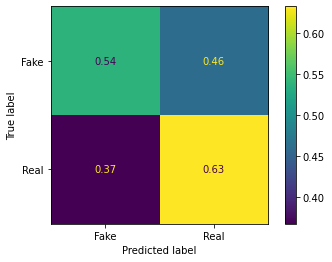

In [ ]:
cm = confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Fake','Real'])
disp.plot()

Random Forest

# CNNs

In [ ]:
x_data, y_data = np.asarray(data)[:,0], np.asarray(data)[:,1]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


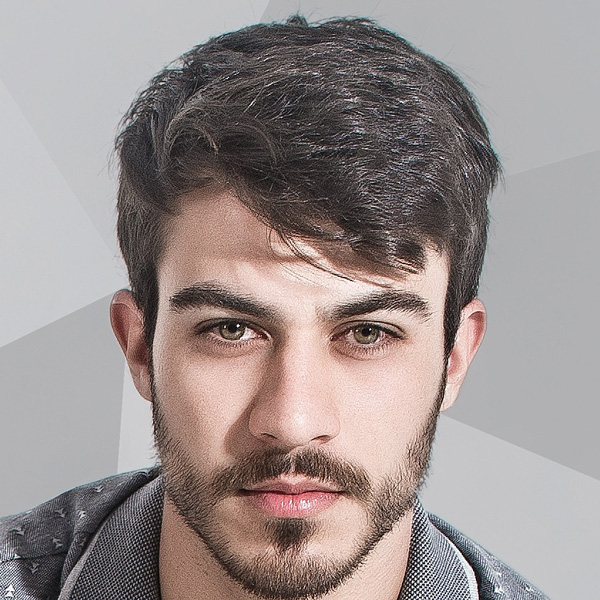

In [ ]:
Image.fromarray(x_data[0])

Random Forest

In [ ]:
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

In [ ]:
print(len(x_train))
print(len(x_test))

NameError: ignored